# Loading pre-trained GloVe word embeddings

In [1]:
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np
from scipy import spatial

urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

!unzip "/content/glove.6B.zip" -d "/content/"

embed_dict = {}
with open('/content/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embed_dict[word]=vector

Archive:  /content/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


# Model


In [ ]:
!pip install bertopic
!pip install octis
!pip uninstall gensim -y
!pip install git+https://github.com/RaRe-Technologies/gensim.git@refs/pull/3172/merge

from google.colab import drive
drive.mount("/content/drive", force_remount=True)
import os
os.chdir("/content/drive/My Drive/Evaluation/")

from octis.dataset.dataset import Dataset
from data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer

In [5]:
import umap
import hdbscan
from bertopic import BERTopic
import tensorflow_hub

# Data loading and preprocessing

**We load the United Nations dataset**

In [6]:
%%time
dataloader = DataLoader(dataset="un_dtm").prepare_docs(save="un_dtm.txt").preprocess_octis(output_folder="un_dtm")

created vocab
31744
words filtering done
CPU times: user 2min 24s, sys: 4.09 s, total: 2min 28s
Wall time: 2min 35s


In [7]:
%%capture

# Prepare data
#dataset, custom = "trump_dtm", True
dataset, custom = "un_dtm", True
data_loader = DataLoader(dataset)
_, timestamps = data_loader.load_docs()
data = data_loader.load_octis(custom)
data = [" ".join(words) for words in data.get_corpus()]

# Match indices
import os
os.listdir(f"./{dataset}")
with open(f"./{dataset}/indexes.txt") as f:
    indices = f.readlines()
    
indices = [int(index.split("\n")[0]) for index in indices]
timestamps = [timestamp for index, timestamp in enumerate(timestamps) if index in indices]
len(data), len(timestamps)

# Model creation

**We recall that our model is composed of a document embedder, followed by a dimension reduction model, a clustering model, and finally performs c-TF-IDF for topic representation.**

We define some useful functions for computing the **c-TF-IDF**.

In [8]:
#######@@@@@@@@ c-TF-IDF @@@@@@@@#######

def c_tf_idf(documents, m, ngram_range=(1, 1)):
  count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
  t = count.transform(documents).toarray()
  w = t.sum(axis=1)
  tf = np.divide(t.T, w)
  sum_t = t.sum(axis=0)
  idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
  tf_idf = np.multiply(tf, idf)
  return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
  '''
  This function extracts the top n words in a topic
  '''
  words = count.get_feature_names()
  labels = list(docs_per_topic.Topic)
  tf_idf_transposed = tf_idf.T
  indices = tf_idf_transposed.argsort()[:, -n:]
  top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
  return top_n_words

def extract_topic_sizes(df):
  topic_sizes = (df.groupby(['Topic'])
                      .Doc
                      .count()
                      .reset_index()
                      .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                      .sort_values("Size", ascending=False))
  return topic_sizes

**Document embedder**

In [9]:
# We load our document embedder model
embedding_model = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # USE is our document embedding model !
topic_model = BERTopic(embedding_model=embedding_model)

**Rest of the model**

We compute directly ...

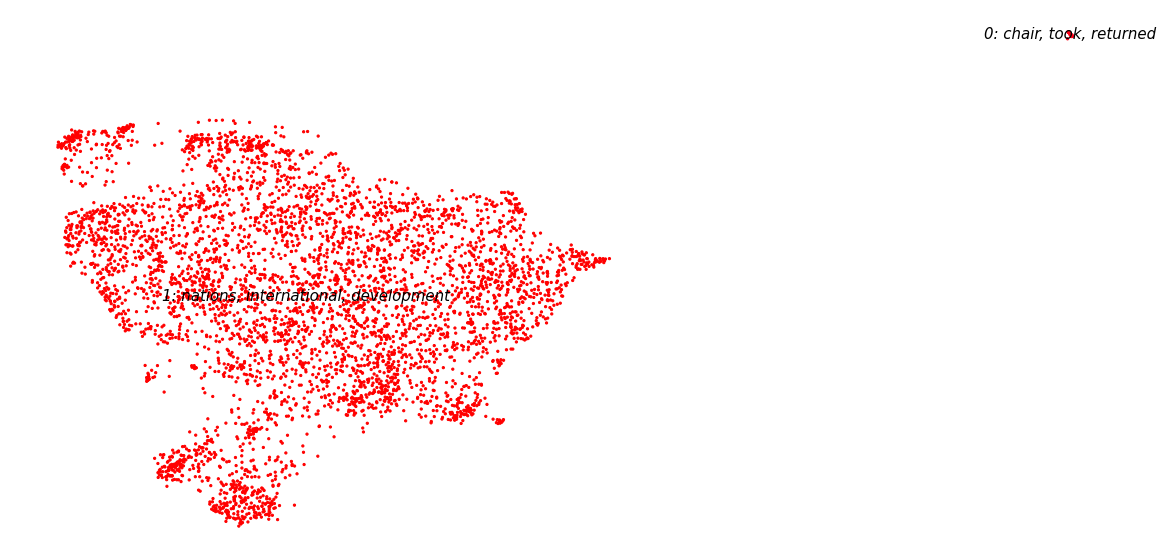

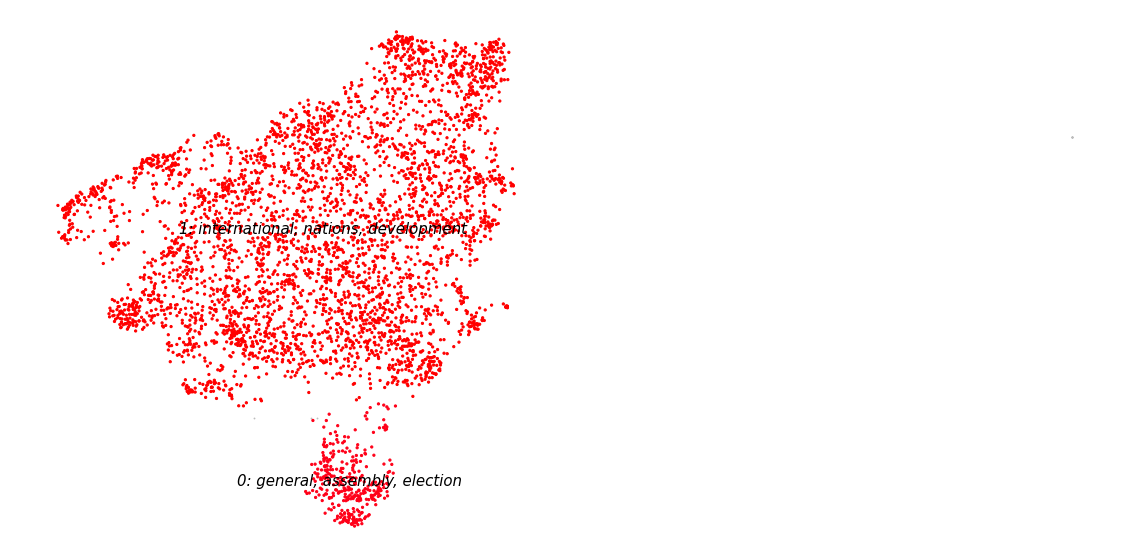

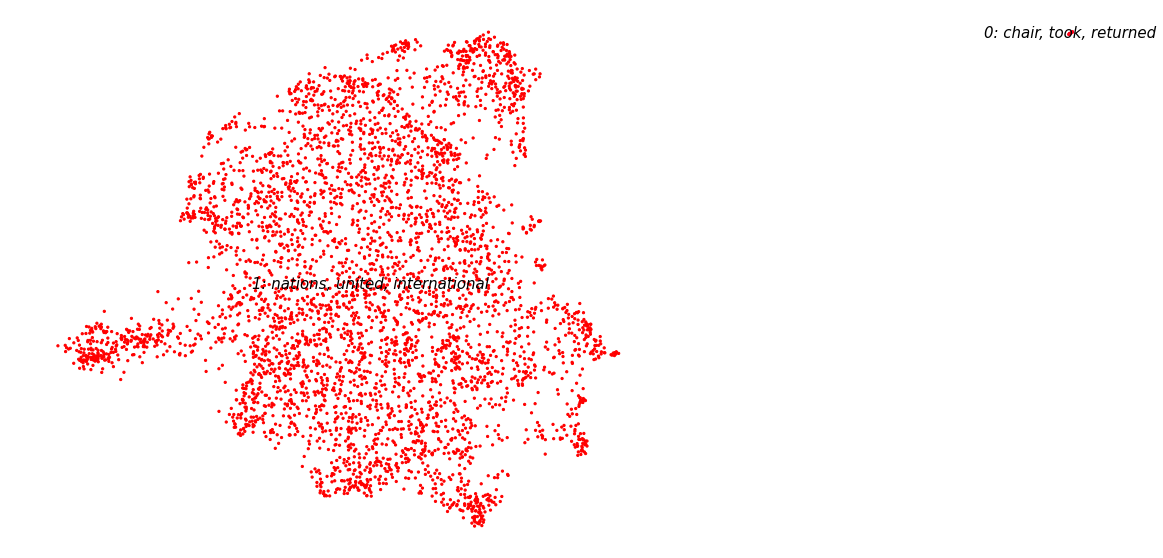

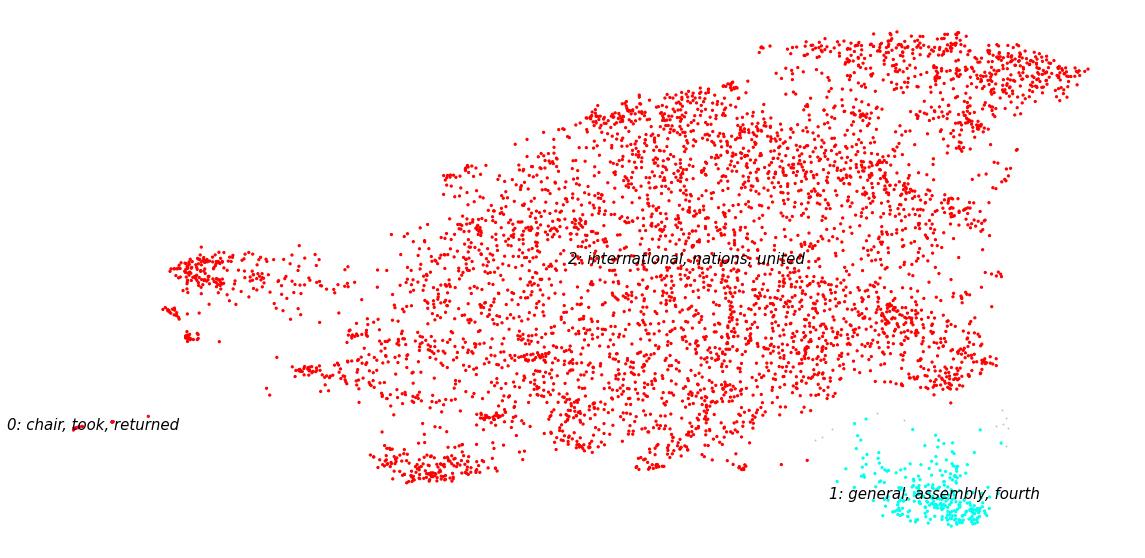

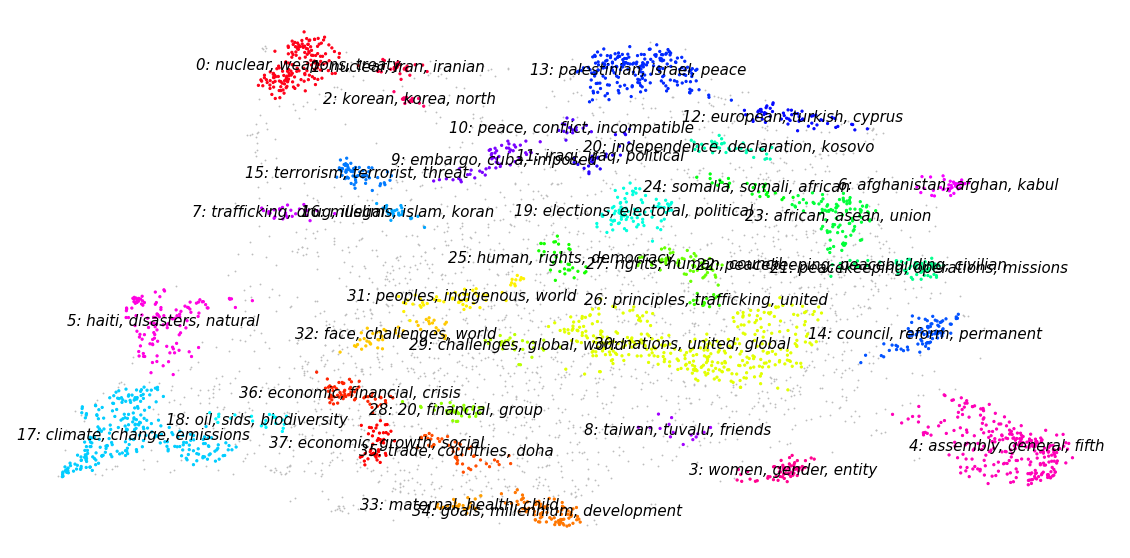

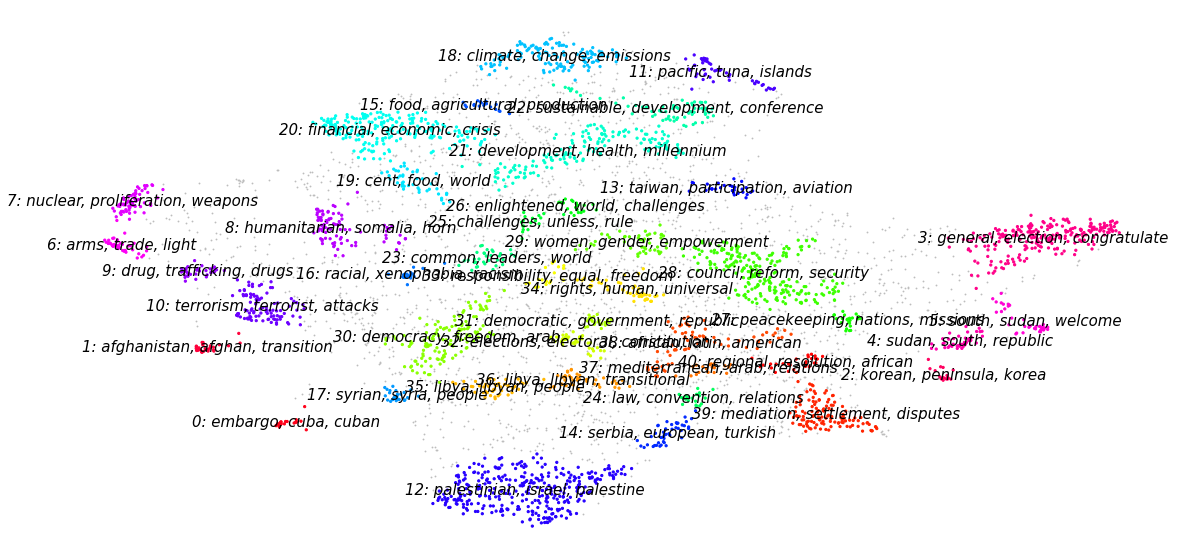

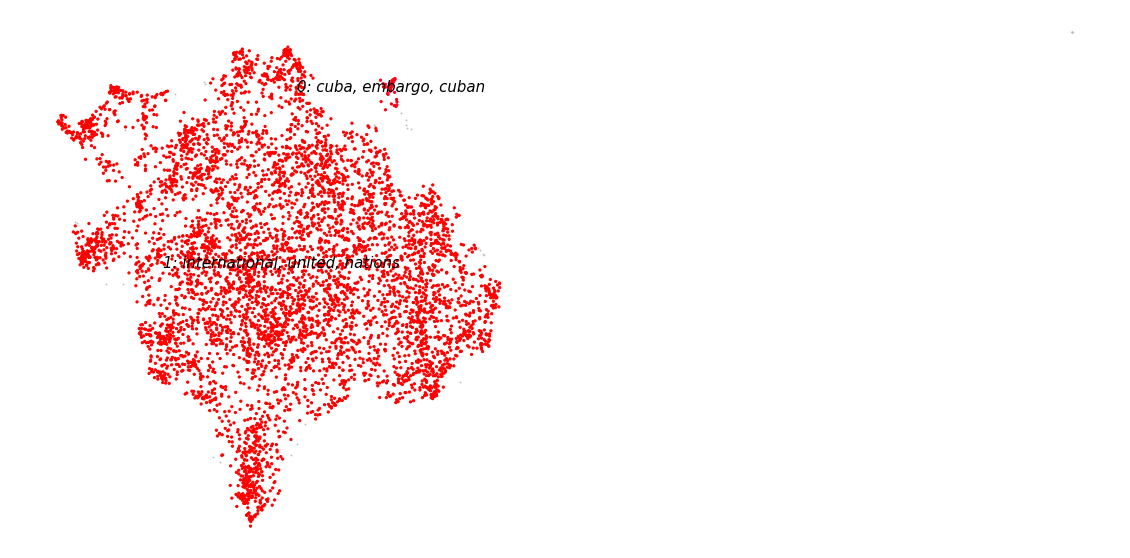

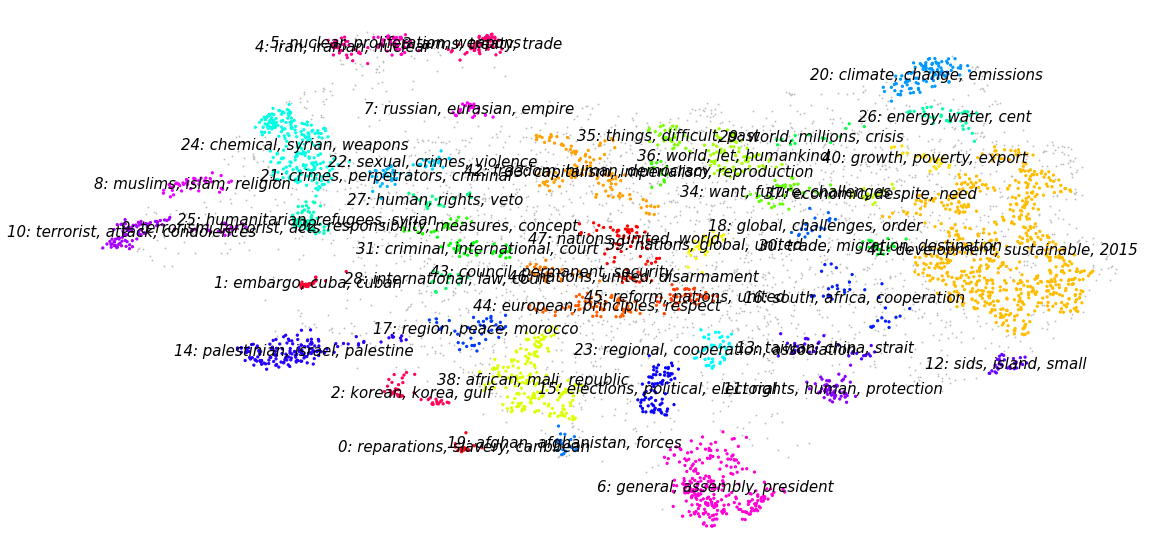

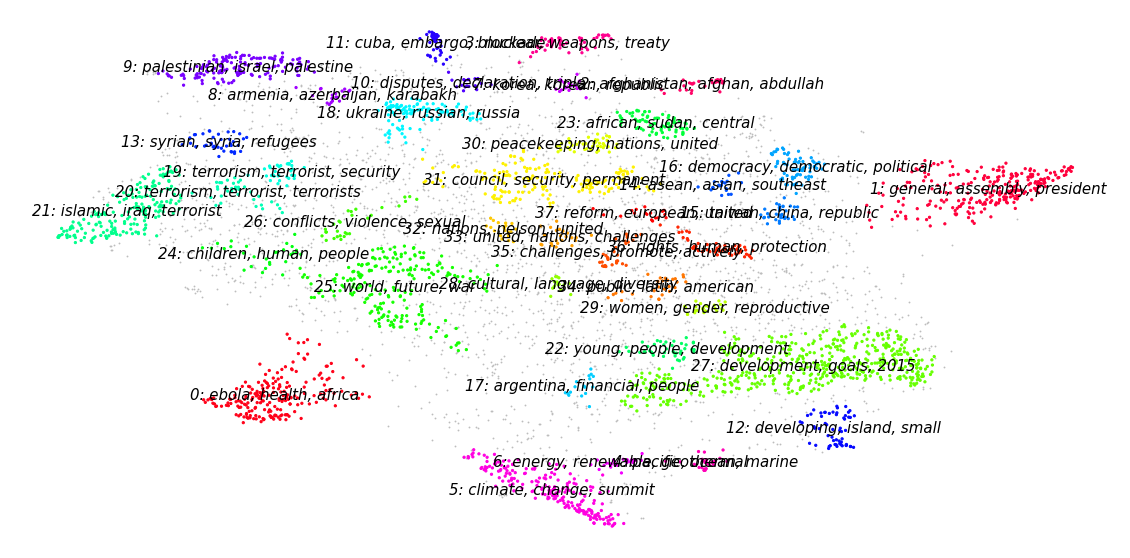

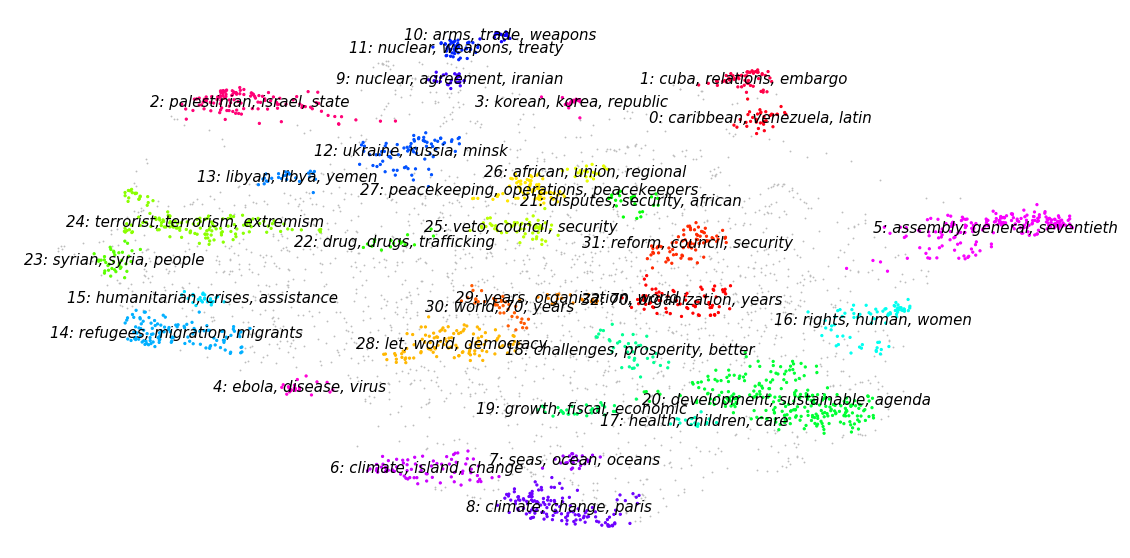

In [10]:
DF = pd.DataFrame({"words":["word"], "embeddings":["embedding"], "topic" : ["topic"], "timestamp" : ["timestamp"]})
TOP_N_WORDS = []

timestamp = np.unique(timestamps)

for t in timestamp : 
  dataframe = pd.DataFrame(data, columns = ["Doc"])
  dataframe["timestamps"] = timestamps
  DATA = dataframe[dataframe["timestamps"] == t].Doc.values

  ####### Embbed the documents #######
  embeddings = embedding_model(DATA)
  embeddings = np.array(embeddings)

  ####### UMAP (dimension) #######
  umap_args = {'n_neighbors': 15,'n_components': 2,'metric': 'cosine'}
  umap_model = umap.UMAP(**umap_args).fit(embeddings)
  umap_model = umap_model.fit(embeddings)
  umap_embeddings = umap_model.transform(embeddings)

  ####### HDBSCAN (clustering) #######
  hdbscan_args = {'min_cluster_size': 15, 'metric': 'euclidean', 'cluster_selection_method': 'eom'} #'min_cluster_size': 15 is the standard value in HDBSCAN
  cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_embeddings)
  #To look at the clusters found by the algorithm, we just need to run "cluster.labels_" or "np.unique(cluster.labels_)"

  # We create a dataframe for the visualization part
  result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
  result['labels'] = cluster.labels_
  result["text"] = DATA

  ########### c-TF-IDF #############
  '''
  Now, we are going to compute the c-TF-IDF value of each word. The function c-tf-idf has been implemented earlier in 
  the code. 
  We start by creating a dataframe "docs_df" to facilitate the computation of c-TF-IDF.
  '''
  docs_df = pd.DataFrame(DATA, columns=["Doc"])
  docs_df['Topic'] = cluster.labels_
  docs_df['Doc_ID'] = range(len(docs_df))
  docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

  ####### c-TF-IDF #######
  tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(DATA))
  # N.B. : "tf-idf" contains the c-TF-IDF values. Hence, we have a single importance value for each word in a cluster *

  ####### Topic representation #######
  top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=22)
  topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


  ####### Plot #######
  '''
  In order to display the words along with the clusters (topics), we need to calculate the topic vectors.
  '''
  unique_labels = set(cluster.labels_)
  # Since topic -1 refers to outliers/noises, we need to remove the noise and work with the "real" topics 
  if -1 in unique_labels:
    unique_labels.remove(-1)

  topic_vectors = np.array([result[result["labels"]== label][["x","y"]].mean() for label in unique_labels])

  # We concatenate the three first words of each topic (for the plot)
  topics = [f"{i}: "+top_n_words[i][0][0]+", "+top_n_words[i][1][0]+", "+top_n_words[i][2][0] for i in range(len(topic_vectors))]
  #topics = [f"Topic {i}" for i in range(len(topic_vectors))]

  # We create a dataframe for the visualization
  result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
  result['labels'] = cluster.labels_
  result["text"] = DATA # We need to change d2006

  # Visualize 2Dembeddings + Topics
  fig, ax = plt.subplots(figsize=(20, 10))
  outliers = result.loc[result.labels == -1, :]
  clustered = result.loc[result.labels != -1, :]
  plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.7)
  plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5,cmap='hsv_r')
  for i in range(len(topic_vectors)) :
    plt.text(topic_vectors[i][0], topic_vectors[i][1], topics[i]
            ,horizontalalignment='center', verticalalignment='center'
            ,fontsize=15, style = 'oblique') #  bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}
    #plt.xlim(0,15)
    #plt.ylim(0,15)
  plt.axis('off')
  #plt.title(f"{len(unique_labels)} topics")


  ############ Word Embeddings ##############
  if -1 in top_n_words :
    topic_matrix = [[top_n_words[i][j][0] for j in range(len(top_n_words[i]))] for i in range(len(top_n_words)-1)] #len(top_n_words)-1
  else :
    topic_matrix = [[top_n_words[i][j][0] for j in range(len(top_n_words[i]))] for i in range(len(top_n_words))]


  # THIS IS FOR PLOTTING THE TOPIC WORDS ! #
  if -1 in top_n_words :
    topic_matrix_proba = [[top_n_words[i][j][1] for j in range(len(top_n_words[i]))] for i in range(len(top_n_words)-1)] #len(top_n_words)-1
  else :
    topic_matrix_proba = [[top_n_words[i][j][1] for j in range(len(top_n_words[i]))] for i in range(len(top_n_words))]

  if -1 in top_n_words :
    del top_n_words[-1]
  TOP_N_WORDS.append(top_n_words)
  # THIS IS FOR PLOTTING THE TOPIC WORDS ! #


  #GloVe = [[embed_dict[topic_matrix[i][j]] for j in range(len(topic_matrix[i]))] for i in range(len(topic_matrix))]
  ##################### Eschew the unknown token prblem ############################
  GloVe = []
  for i in range(len(topic_matrix)):
    A = []
    for j in range(len(topic_matrix[i])):
      if topic_matrix[i][j] in embed_dict :
        A.append(embed_dict[topic_matrix[i][j]])
      else :
        B = [0 for i in range(200)]
        A.append(B)
    GloVe.append(A)
  ##################################################################################

  df0 = pd.DataFrame(topic_matrix[0], columns = ["words"])
  df0["proba"] = topic_matrix_proba[0]
  df0["embeddings"] = GloVe[0]
  df0["topic"] = 0
  df0["timestamp"] = t
  for i in range(1, len(topic_matrix)) :
    df1 = pd.DataFrame(topic_matrix[i], columns = ["words"])
    df1["proba"] = topic_matrix_proba[i]
    df1["embeddings"] = GloVe[i]
    df1["topic"] = i
    df1["timestamp"] = t
    df0 = df0.append(df1)
  DF = DF.append(df0)


# Chamfer distance

**We compute the Chamfer distance betwenn topics accross time.**

In [ ]:
!pip install chamferdist

import torch
import tensorflow as tf
from chamferdist import ChamferDistance

# Initialize Chamfer distance module
chamferDist = ChamferDistance()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for chamferdist: filename=chamferdist-1.0.0-cp37-cp37m-linux_x86_64.whl size=2634255 sha256=980ca075dc8baef3753bd0d31ca351756636b9d1bd48c2a441d115cfb0a2cde4
  Stored in directory: /root/.cache/pip/wheels/28/bb/d1/c789ecd6835e466e813f6e2c5e23bb1bbb2248e84586ba82d2
Successfully built chamferdist


We create a dataframe CD containing the chamfer distances between topics at each timestamp.

In [ ]:
CD = pd.DataFrame(columns=['timestamp','topic 1','topic 2','CD'])
k = 0
for t in range(len(timestamp)-1) :
  for topic_i in np.unique(DF[DF["timestamp"] == timestamp[t]]["topic"].values.tolist()) :
    topic0 = DF[(DF["timestamp"] == timestamp[t]) & (DF["topic"] == topic_i)]["embeddings"].values.tolist() # We retrieve the word embeddings of the topic representation of i-th topic at time t.
    for topic_j in np.unique(DF[DF["timestamp"] == timestamp[t+1]]["topic"].values.tolist()) :
      topic1 = DF[(DF["timestamp"] == timestamp[t+1]) & (DF["topic"] == topic_j)]["embeddings"].values.tolist() # We retrieve the word embeddings of the topic representation of j-th topic at time t+1
      ########################################
      ########## Calculation of CD ###########
      source_cloud = torch.as_tensor([topic0])
      target_cloud = torch.as_tensor([topic1])
      dist_forward = chamferDist(source_cloud, target_cloud) # Forward Chamfer Distance
      ########################################
      # We can now fill the CD dataframe
      k += 1
      CD.loc[k] = pd.Series({'timestamp':timestamp[t], 'topic 1':topic_i, 'topic 2':topic_j, 'CD':dist_forward.detach().cpu().item()}) # We should replace "topic_i" & "topic_j" by their word representation !


# Visualize the boxplots of CD values

In [ ]:
def sorted_CD(CD, time_t, topic) :
  '''
  Given a time t and a topic A, this function returns the top N topics at time t+1 that have the smallest CD values with topic A 
  (ranked in increasing order), and also returns the corrersponding CD values.

  CD := is the Chamfer distance dataframe, it is composed of the columns "time", "topic 1", "topic 2" and "CD".
  time_t := is time t 
  topic := is the topic A (at time t).
  N := corresponds to the number of topics and CD values we retrieve

  topN_minCD := is a list containing the N smallest CD values (sorted in increasing order)
  topics_topN_minCD := is a list containing the topics corresponding to the topN_minCD values.
  '''
  dataframe = CD[(CD["timestamp"] == time_t) & (CD["topic 1"] == topic)][["topic 2","CD"]]
  N = len(dataframe)
  topN_minCD = dataframe['CD'].nsmallest(N).values.tolist()
  topics_topN_minCD = []
  for k in topN_minCD :
    topic_k = dataframe[dataframe["CD"] == k]["topic 2"].values.tolist()[0]
    topics_topN_minCD.append(topic_k)
 
  return topN_minCD, topics_topN_minCD


def bp_dataframe(CD) :
  BP = pd.DataFrame(columns = ["timestamp", "topic of reference", "ranking", "distance"])
  for timestamp in np.unique(CD["timestamp"].values.tolist()) :
    for topic_ref in np.unique(CD[(CD["timestamp"] == timestamp)]["topic 1"].values.tolist()):
        distances, A = sorted_CD(CD, timestamp, topic_ref)
        time = [timestamp for i in range(len(distances))]
        topicref = [topic_ref for i in range(len(distances))]
        BP1 = pd.DataFrame(columns = ["timestamp", "topic of reference", "ranking", "distance"])
        BP1["timestamp"] = time
        BP1["topic of reference"] = topicref
        BP1["ranking"] = [i+1 for i in range(len(distances))]
        BP1["distance"] = distances
        BP = BP.append(BP1)
  return BP


CD2 = bp_dataframe(CD)

In [ ]:
import plotly.graph_objects as go
import numpy as np

y_data = [CD2[CD2["ranking"] == i]["distance"].values.tolist() for i in np.unique(CD2["ranking"].values.tolist()) ]
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(170, 360, len(y_data))]
x_data = [i+1 for i in range(len(y_data))]

# Each box is represented by a dict that contains the data, the type, and the colour.
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
fig = go.Figure(data=[go.Box(
    y=CD2[CD2["ranking"] == np.unique(CD2["ranking"].values.tolist())[i]]["distance"].values.tolist(),
    marker_color=c[i]
    ) for i in range(len(np.unique(CD2["ranking"].values.tolist())))])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title = "Ranking (increasing order)"),
    yaxis=dict(zeroline=False, gridcolor='white', title = "Distance (CD)"),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

fig.show()

# Word Mover Distance

In [11]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Loading a pre-trained word embedding model 
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


**We calculate the WMD between topics and store the results in a dataframe WMD**

In [20]:
WMD = pd.DataFrame(columns=['timestamp','topic 1','topic 2','wmd'])
k = 0
for t in range(len(timestamp)-1) :
  for topic_i in np.unique(DF[DF["timestamp"] == timestamp[t]]["topic"].values.tolist()) :
    topic0 = DF[(DF["timestamp"] == timestamp[t]) & (DF["topic"] == topic_i)]["words"].values.tolist() # We retrieve the topic words of i-th topic at time t.
    for topic_j in np.unique(DF[DF["timestamp"] == timestamp[t+1]]["topic"].values.tolist()) :
      topic1 = DF[(DF["timestamp"] == timestamp[t+1]) & (DF["topic"] == topic_j)]["words"].values.tolist() # We retrieve the topic word of j-th topic at time t+1
      ########## Calculation of WMD ###########
      wmd = model.wmdistance(topic0, topic1)
      ########################################
      # We can now fill the WMD dataframe
      k += 1
      WMD.loc[k] = pd.Series({'timestamp':timestamp[t], 'topic 1':topic_i, 'topic 2':topic_j, 'wmd':wmd}) # We should replace "topic_i" & "topic_j" by their word representation !


In [26]:
def sorted_WMD(WMD, time_t, topic) :
  '''
  Given a time t and a topic A, this function returns the top N topics at time t+1 that have the smallest wmd values with topic A 
  (ranked in increasing order), and also returns the corrersponding wmd values.

  WMD := is the WMD dataframe, it is composed of the columns "time", "topic 1", "topic 2" and "wmd".
  time_t := is time t 
  topic := is the topic A (at time t).
  N := corresponds to the number of topics and wmd values we retrieve

  topN_minWMD := is a list containing the N smallest wmd values (sorted in decreasing order)
  topics_topN_minWMD := is a list containing the topics corresponding to the topN_minWMD values.
  '''
  dataframe = WMD[(WMD["timestamp"] == time_t) & (WMD["topic 1"] == topic)][["topic 2","wmd"]]
  N = len(dataframe)
  topN_minWMD = dataframe['wmd'].nsmallest(N).values.tolist()
  topics_topN_minWMD = []
  for k in topN_minWMD :
    topic_k = dataframe[dataframe["wmd"] == k]["topic 2"].values.tolist()[0]
    topics_topN_minWMD.append(topic_k)
 
  return topN_minWMD, topics_topN_minWMD


def bp_dataframe_wmd(WMD) :
  BP = pd.DataFrame(columns = ["timestamp", "topic of reference", "ranking", "distance"])
  for timestamp in np.unique(WMD["timestamp"].values.tolist()) :
    for topic_ref in np.unique(WMD[(WMD["timestamp"] == timestamp)]["topic 1"].values.tolist()):
        distances, A = sorted_WMD(WMD, timestamp, topic_ref)
        time = [timestamp for i in range(len(distances))]
        topicref = [topic_ref for i in range(len(distances))]
        BP1 = pd.DataFrame(columns = ["timestamp", "topic of reference", "ranking", "distance"])
        BP1["timestamp"] = time
        BP1["topic of reference"] = topicref
        BP1["ranking"] = [i+1 for i in range(len(distances))]
        BP1["distance"] = distances
        BP = BP.append(BP1)
  return BP


WMD2 = bp_dataframe_wmd(WMD)

In [27]:
import plotly.graph_objects as go
import numpy as np

y_data = [WMD2[WMD2["ranking"] == i]["distance"].values.tolist() for i in np.unique(WMD2["ranking"].values.tolist()) ]
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(170, 360, len(y_data))]
x_data = [i+1 for i in range(len(y_data))]

# Each box is represented by a dict that contains the data, the type, and the colour.
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
fig = go.Figure(data=[go.Box(
    y=WMD2[WMD2["ranking"] == np.unique(WMD2["ranking"].values.tolist())[i]]["distance"].values.tolist(),
    marker_color=c[i]
    ) for i in range(len(np.unique(WMD2["ranking"].values.tolist())))])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title = "Ranking (increasing order)"),
    yaxis=dict(zeroline=False, gridcolor='white', title = "Distance (WMD)"),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

fig.show()

In [ ]:
print(DF[(DF["timestamp"] == 2010) & (DF["topic"] == 9)]["words"].values.tolist())
print(DF[(DF["timestamp"] == 2011) & (DF["topic"] == 0)]["words"].values.tolist())
print(DF[(DF["timestamp"] == 2012) & (DF["topic"] == 0)]["words"].values.tolist())
print(DF[(DF["timestamp"] == 2013) & (DF["topic"] == 1)]["words"].values.tolist())
print(DF[(DF["timestamp"] == 2014) & (DF["topic"] == 11)]["words"].values.tolist())
print(DF[(DF["timestamp"] == 2015) & (DF["topic"] == 1)]["words"].values.tolist())